<a href="https://colab.research.google.com/github/priyasi345/tensorflow_quantum_ml/blob/master/qml3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 3.9MB 34.3MB/s 
     |████████████████████████████████| 450kB 38.2MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [2]:
!pip install -q tensorflow-quantum

     |████████████████████████████████| 3.9MB 2.8MB/s 
     |████████████████████████████████| 1.4MB 33.3MB/s 
     |████████████████████████████████| 5.3MB 38.9MB/s 
     |████████████████████████████████| 163kB 44.5MB/s 
     |████████████████████████████████| 1.2MB 40.3MB/s 
     |████████████████████████████████| 112kB 45.2MB/s 
     |████████████████████████████████| 133kB 41.2MB/s 


In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loads the raw data from Keras.
Filters the dataset to only 3s and 6s.
Downscales the images so they fit can fit in a quantum computer.
Removes any contradictory examples.
Converts the binary images to Cirq circuits.
Converts the Circ circuits to TensorFlow Quantum circuits.

In [6]:
#Loads the raw data from Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [7]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [8]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


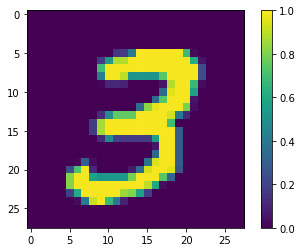

In [9]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [10]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


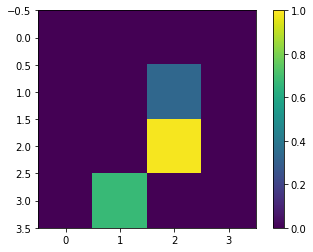

In [11]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
      labels = mapping[tuple(x.flatten())]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(list(labels)[0])
      else:
          # Throw out images that match more than one label.
          pass
    
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(xs))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [13]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of 3s:  4961
Number of 6s:  5475
Number of contradictory images:  49

Initial number of examples:  12049
Remaining non-contradictory examples:  11520


In [14]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [15]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


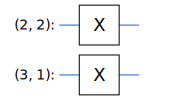

In [16]:
SVGCircuit(x_train_circ[0])

In [17]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [18]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [19]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

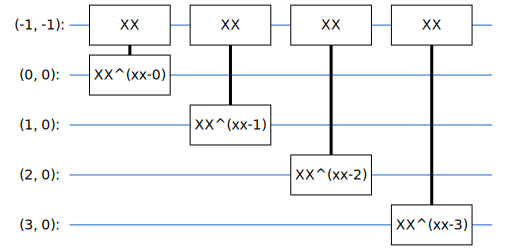

In [20]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [21]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [22]:
model_circuit, model_readout = create_quantum_model()

Wrap the model-circuit in a tfq-keras model

In [23]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [24]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [25]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [26]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


Train the quantum model

In [28]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [29]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [30]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 11520 samples, validate on 1968 samples
Epoch 1/3
11520/11520 [==============================] - 6212s 539ms/sample - loss: 0.6617 - hinge_accuracy: 0.7331 - val_loss: 0.4722 - val_hinge_accuracy: 0.7520
Epoch 2/3
11520/11520 [==============================] - 6238s 541ms/sample - loss: 0.3725 - hinge_accuracy: 0.8523 - val_loss: 0.3517 - val_hinge_accuracy: 0.8947
Epoch 3/3
1968/1968 [==============================] - 34s 17ms/sample - loss: 0.3337 - hinge_accuracy: 0.8725


In [31]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [33]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

Train on 12049 samples, validate on 1968 samples
1968/1968 [==============================] - 0s 136us/sample - loss: 0.0013 - accuracy: 1.0000


In [34]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Train on 11520 samples, validate on 1968 samples
Epoch 1/20
11520/11520 - 1s - loss: 0.6960 - accuracy: 0.5027 - val_loss: 0.6942 - val_accuracy: 0.4868
Epoch 2/20
11520/11520 - 0s - loss: 0.6935 - accuracy: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.4868
Epoch 3/20
11520/11520 - 0s - loss: 0.6929 - accuracy: 0.5027 - val_loss: 0.6925 - val_accuracy: 0.4868
Epoch 4/20
11520/11520 - 0s - loss: 0.6889 - accuracy: 0.5027 - val_loss: 0.6772 - val_accuracy: 0.4868
Epoch 5/20
11520/11520 - 0s - loss: 0.6475 - accuracy: 0.5027 - val_loss: 0.6073 - val_accuracy: 0.4868
Epoch 6/20
11520/11520 - 0s - loss: 0.5558 - accuracy: 0.5027 - val_loss: 0.5182 - val_accuracy: 0.4868
Epoch 7/20
11520/11520 - 0s - loss: 0.4804 - accuracy: 0.5027 - val_loss: 0.4647 - val_accuracy: 0.4868
Epoch 8/20
11520/11520 - 0s - loss: 0.4339 - accuracy: 0.5027 - val_loss: 0.4256 - val_accuracy: 0.4868
Epoch 9/20
11520/11520 - 0s - loss: 0.3998 - accuracy: 0.7713 - val_loss: 0.3952 - val_accuracy: 0.8039
Epoch 10/20
115

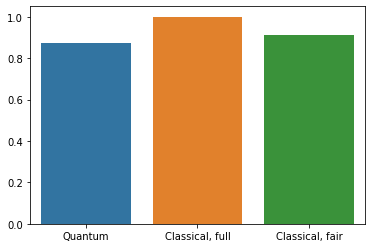

In [36]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])